# REINFORCE algorithm

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.agents.reinforce.reinforce_agent import ReinforceAgent
from tf_agents.utils import common as cmn

import matplotlib.pyplot as plt
import qutip
from qutip import sigmap, expect

import random

import sys
sys.path.append('../')
from common.common import get_average_return, extract_double_action_policy

%matplotlib inline

* System parameters

In [12]:
T = 3.5 # terminal time step
max_steps = 30 # number of time steps
seed = 1989
random.seed(seed)
tf.random.set_seed(seed)

* Create training and evaluation environments and define actions

In [13]:
# validate environment
from environments.qubit_env import QubitContinuousEnv

# define actions
# TODO: actions can be continuous within a range of course 
# actions will be the change in the magnetic field
max_Ω = 1.0
max_Δ = 0.5

environment = QubitContinuousEnv(T, max_steps, max_Ω, max_Δ, fidelity_threshold = 0.9999, verbose_fg = False)
eval_environment = QubitContinuousEnv(T, max_steps, max_Ω, max_Δ, fidelity_threshold = 0.9999, verbose_fg = False)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

In [14]:
fc_layer_params = (100, 75)
learning_rate = 1e-3
replay_buffer_capacity = 10000
num_iterations = 3000
nb_episodes = 5
eval_interval = 10
checkpoint_dir = "../checkpoints/reinforce_qubit_omega_detuning_e-4_error/"

In [15]:
actor_network = actor_distribution_network.ActorDistributionNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    name = "Policy",
)

# use tha Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

value_net = value_network.ValueNetwork(
    input_tensor_spec = train_env.observation_spec(),
    fc_layer_params = (75, 50),
    name = 'ValueNet'
) 

agent = ReinforceAgent(
    time_step_spec = environment.time_step_spec(),
    action_spec = environment.action_spec(),
    actor_network = actor_network,
    value_network = value_net,
    optimizer = optimizer,
    normalize_returns = True,
    train_step_counter = train_step_counter,
    gamma = 0.99,
    gradient_clipping = 1
)

agent.initialize()

In [16]:
# collect trajectories
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = None,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = cmn.function(agent.train)

# Reset the train step.
# agent.train_step_counter.assign(0)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function = True),
    observers = [rb_observer],
    max_episodes = nb_episodes
)

# create checkpointer to load training and continue
""" checkpointer = cmn.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmptvx1yjgc.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmptvx1yjgc
[reverb/cc/platform/default/server.cc:71] Started replay server on port 33917
[reverb/cc/platform/default/server.cc:84] Shutting down replay server


' checkpointer = cmn.Checkpointer(\n    ckpt_dir = checkpoint_dir,\n    max_to_keep = 1,\n    agent = agent,\n    policy = agent.policy,\n    replay_buffer = replay_buffer,\n)\n\ncheckpointer.initialize_or_restore() '

In [17]:
avg_returns = [get_average_return(eval_env, agent.policy, 10)]

for _ in range(num_iterations):
    initial_time_step = environment.reset()
    collect_driver.run(initial_time_step)

    # create dataset from trajectories
    dataset = replay_buffer.as_dataset(sample_batch_size = 1)
    iterator = iter(dataset)

    trajectories , _ = next(iterator)

    # train 
    train_loss = agent.train(experience = trajectories)

    replay_buffer.clear()

    step = agent.train_step_counter.numpy()

    if step % 50 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = get_average_return(eval_env, agent.policy, 10)
        avg_returns.append(avg_return)

        if step > 2500 and avg_return > -5:
            break


step = 50: loss = 75.32821655273438
step = 100: loss = 34.303550720214844
step = 150: loss = 10.607318878173828
step = 200: loss = 4.180263042449951
step = 250: loss = 6.940698146820068
step = 300: loss = 5.098427772521973
step = 350: loss = -2.316826105117798
step = 400: loss = -1.340660810470581
step = 450: loss = -3.318854331970215
step = 500: loss = -7.880790710449219
step = 550: loss = -1.9028120040893555
step = 600: loss = 9.502481460571289
step = 650: loss = 5.463771820068359
step = 700: loss = -2.851020336151123
step = 750: loss = -0.5612578988075256
step = 800: loss = 0.2687057852745056
step = 850: loss = -7.373612403869629
step = 900: loss = 4.746879577636719
step = 950: loss = 4.786826133728027
step = 1000: loss = -0.49268049001693726
step = 1050: loss = 426.7097473144531


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (388631) so Table uniform_table is accessed directly without gRPC.


step = 1100: loss = -1.0585646629333496
step = 1150: loss = 8.82970905303955
step = 1200: loss = -2.196011781692505
step = 1250: loss = -5.260457992553711
step = 1300: loss = 7.448807716369629
step = 1350: loss = -4.202789783477783
step = 1400: loss = 3.1033334732055664
step = 1450: loss = -2.11667537689209
step = 1500: loss = -6.4906134605407715
step = 1550: loss = 6.1148457527160645
step = 1600: loss = -3.7782654762268066
step = 1650: loss = -2.8518264293670654
step = 1700: loss = 1.843583583831787
step = 1750: loss = 6.9382643699646
step = 1800: loss = -9.947924613952637
step = 1850: loss = -3.633364677429199
step = 1900: loss = 1.9055981636047363
step = 1950: loss = -1.4439014196395874
step = 2000: loss = -1.6316063404083252
step = 2050: loss = -1.6189918518066406
step = 2100: loss = -3.060154676437378
step = 2150: loss = 3.1339614391326904
step = 2200: loss = -4.788567543029785
step = 2250: loss = -1.4581100940704346
step = 2300: loss = 7.764579772949219
step = 2350: loss = -2.046

In [18]:
# checkpointer.save(train_step_counter)

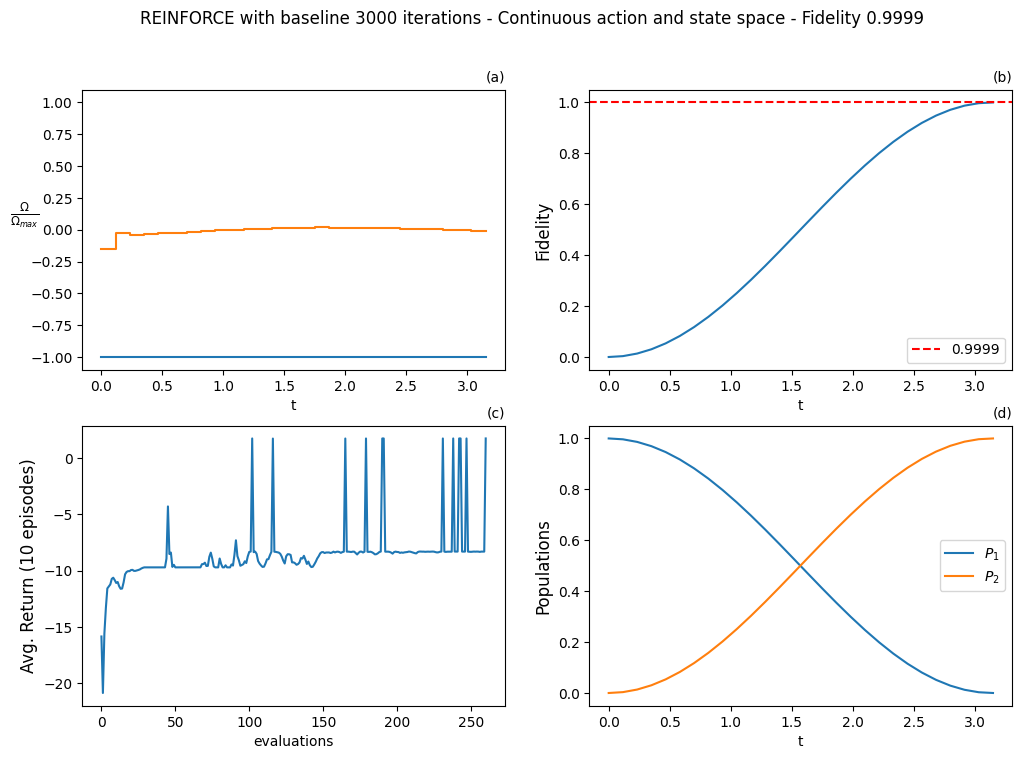

In [19]:
greedy_actions, [optimal_omegas, optimal_detuning], states, fidelities = extract_double_action_policy(environment, agent)

population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

time_span = np.arange(len(optimal_omegas))
time_span = [t * T / max_steps for t in time_span]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f'REINFORCE with baseline {num_iterations} iterations - Continuous action and state space - Fidelity 0.9999')

ax1.step(time_span, optimal_omegas, where = 'post', label = 'Ω')
ax1.step(time_span, optimal_detuning, where = 'post', label = 'Δ')
ax1.set_ylabel(r"$\frac{\Omega}{\Omega_{max}}$", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlabel(f"t")
ax1.set_title("(a)", loc = "right", fontsize = 10)

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.9999, color = 'r', linestyle = '--', label = '0.9999')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"t")
ax2.legend(loc = 'lower right')
ax2.set_title("(b)", loc = "right", fontsize = 10)

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(f"t")
ax4.set_title("(d)", loc = "right", fontsize = 10)
ax4.legend()

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Avg. Return (10 episodes)", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
ax3.set_title("(c)", loc = "right", fontsize = 10)

plt.show()

In [20]:
fidelities

[0.0,
 0.0033988344168976547,
 0.013548933473043758,
 0.030312221905797028,
 0.05346042856260553,
 0.08267866448918668,
 0.11756957589181359,
 0.15765883408723827,
 0.20240158605903263,
 0.25118980752929476,
 0.30336051793436924,
 0.35820474289989446,
 0.4149771090399296,
 0.47290594791124513,
 0.5312037985544551,
 0.5890781030551978,
 0.6457419286233059,
 0.7004246775102778,
 0.7523826688165293,
 0.8009093212671388,
 0.8453447593601567,
 0.8850847822592316,
 0.9195890921516346,
 0.9483886369279931,
 0.9710919395286942,
 0.9873903925175963,
 0.9970624936166406,
 0.9999768592870926]